# **Homework 1: Linear Regression**

## **goal**

本次目標：由前 9 個小時的 18 個 features (包含 PM2.5)預測的 10 個小時的 PM2.5。<!-- 可以參考 <link> 獲知更細項的作業說明。-->

<!-- 首先，從 https://drive.google.com/open?id=1El0zvTkrSuqCTDcMpijXpADvJzZC2Jpa 將整個資料夾下載下來，並將下載下來的資料夾放到自己的 Google Drive（注意：上傳到自己 Google Drive 的是資料夾 hw1-regression，而非壓縮檔） -->

 ----- strong baseline -----   7.14231

----- simple baseline -----   8.73773

# **Load 'train.csv'**
train.csv 的資料為 12 個月中，每個月取 20 天，每天 24 小時的資料(每小時資料有 18 個 features)。

In [65]:
import sys
import pandas as pd
import numpy as np
!gdown --id '1wNKAxQ29G15kgpBy_asjTcZRRgmsCZRm' --output data.zip # download the dataset as data.zip
!unzip data.zip # unzip data.zip
data = pd.read_csv('./train.csv', encoding = 'big5')

Downloading...
From: https://drive.google.com/uc?id=1wNKAxQ29G15kgpBy_asjTcZRRgmsCZRm
To: /content/data.zip
100% 177k/177k [00:00<00:00, 22.3MB/s]
Archive:  data.zip
replace test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


查看我們的資料樣式

In [ ]:
# data

# **Preprocessing** 
取需要的數值部分，將 'RAINFALL' 欄位全部補 0。
另外，如果要在 colab 重覆這段程式碼的執行，請從頭開始執行(把上面的都重新跑一次)，以避免跑出不是自己要的結果（若自己寫程式不會遇到，但 colab 重複跑這段會一直往下取資料。意即第一次取原本資料的第三欄之後的資料，第二次取第一次取的資料掉三欄之後的資料，...）。

In [66]:
data = data.iloc[:, 3:] # 選取標籤 'data' 且只取第三行開始後，選完的類型仍是 dataframe
data[data == 'NR'] = 0 # 判斷 'RAINFALL' == 'NR' 時補 0
raw_data = data.to_numpy() # to_numpy() 返回代表给定 Series 或 Index 中的值的 NumPy ndarray，在這裡將 data 的內容用 raw_data 以 numpy 存入
# print(raw_data)

# **Extract Features (1)**
![圖片說明](https://drive.google.com/uc?id=1LyaqD4ojX07oe5oDzPO99l9ts5NRyArH)
![圖片說明](https://drive.google.com/uc?id=1ZroBarcnlsr85gibeqEF-MtY13xJTG47)

將原始 4320 * 18 的資料依照每個月分重組成 12 個 18 (features) * 480 (hours) 的資料。 

In [67]:
# 將原始 4320 * 18 的資料依照每個月分重組成 12 個 18 (features) * 480 (hours) 的資料。
# 4320 = 20日*24hr(每日)*18(features)
month_data = {} # 使用 list 儲存每個月的資料 
for month in range(12): # 代表 12 個月
    sample = np.empty([18, 480]) # 創造一個 18*480 的空元素 np array
    for day in range(20):
        sample[:, day * 24 : (day + 1) * 24] = raw_data[18 * (20 * month + day) : 18 * (20 * month + day + 1), :]
    month_data[month] = sample

# **Extract Features (2)**
![alt text](https://drive.google.com/uc?id=1wKoPuaRHoX682LMiBgIoOP4PDyNKsJLK)
![alt text](https://drive.google.com/uc?id=1FRWWiXQ-Qh0i9tyx0LiugHYF_xDdkhLN)

每個月會有 480hrs，每 9 小時形成一個 data，每個月會有 471 個 data，故總資料數為 471 * 12 筆，而每筆 data 有 9 * 18 的 features (一小時 18 個 features * 9 小時)。

對應的 target 則有 471 * 12 個(第 10 個小時的 PM2.5)

In [96]:
x = np.empty([12 * 471, 18 * 9], dtype = float) #橫軸：18個features有九小時資料，縱軸：12個月*471 data
y = np.empty([12 * 471, 1 * 1], dtype = float)
# 第一個氣體放九小時資料後，換下一行放下一個氣體
# 直到放出18個氣體後，就是下一天
for month in range(12):
    for day in range(20):
        for hour in range(24):
            if day == 19 and hour > 14:
                continue
            x[month * 471 + day * 24 + hour, :] = month_data[month][:,day * 24 + hour : day * 24 + hour + 9].reshape(1, -1) # vector dim:18*9 (9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9)
            y[month * 471 + day * 24 + hour, 0] = month_data[month][9, day * 24 + hour + 9] # value
            
# print(x) # training_data
# print(y) # pm2.5

# **Normalize (1)**


In [97]:
mean_x = np.mean(x, axis = 0) #18 * 9 # axis = 0: 針對逐 column 的 mean
std_x = np.std(x, axis = 0) #18 * 9 # axis = 0: 針對逐 column 的 std
# 得到的 mean_x、std_x 為 162*1 的 array，代表著九個小時內的所有 feature 針對 12*471 筆資料的平均
for i in range(len(x)): # 12 * 471
    for j in range(len(x[0])): # 18 * 9 得到每個feature在
        if std_x[j] != 0:
            x[i][j] = (x[i][j] - mean_x[j]) / std_x[j] #歸一化資料，可以比較好訓練
# print(x)

#**Split Training Data Into "train_set" and "validation_set"**
這部分是針對作業中 report 的第二題、第三題做的簡單示範，以生成比較中用來訓練的 train_set 和不會被放入訓練、只是用來驗證的 validation_set。

In [70]:
import math
# 資料量 train : val = 4 : 1
x_train_set = x[: math.floor(len(x) * 0.8), :]
y_train_set = y[: math.floor(len(y) * 0.8), :]
x_validation = x[math.floor(len(x) * 0.8): , :]
y_validation = y[math.floor(len(y) * 0.8): , :]
# print(x_train_set)
# print(y_train_set)
# print(x_validation)
# print(y_validation)
# print(len(x_train_set))
# print(len(y_train_set))
# print(len(x_validation))
# print(len(y_validation))

## **這裡實作 hw1 第二題：**     
比較取前 5 hrs 和前 9 hrs 的資料（5 * 18 + 1 v.s 9 * 18 + 1）在 validation set 上預測的結果，並說明造成的可能原因。
1.   因為 testing set 預測結果要上傳 Kaggle 後才能得知，所以在報告中並不要求同學們呈現 testing set 的結果，至於什麼是 validation set 請參考：https://youtu.be/D_S6y0Jm6dQ?t=1949）

2.   9hr:取前9小時預測第10小時的PM2.5；5hr:在前面的那些features中，以5~9hr預測第10小時的PM2.5。這樣兩者在相同的validation set比例下，會有一樣筆數的資料


In [ ]:
# 這裡實作 9hr，記得使用 train、val set

dim = 18 * 9 + 1 # 因為常數項 (bias) 所以多加一欄
w_9 = np.zeros([dim, 1])
x_train_set_9 = np.concatenate((np.ones([math.floor(12 * 471*0.8), 1]), x_train_set), axis = 1).astype(float) # 使用 np.concatenate 對 "axis = 1 (行)" 的數組拼接
x_validation_9 = np.concatenate((np.ones([1131, 1]), x_validation), axis = 1).astype(float)
train_loss_9 = []
predict_9 = []

learning_rate = 200 # 每次移動多少
iter_time = 40000 # 進行幾次
adagrad = np.zeros([dim, 1])
eps = 0.0000000001
for t in range(iter_time):
    # for training process
    loss = np.sqrt(np.sum(np.power(np.dot(x_train_set_9, w_9) - y_train_set, 2))/471/12) # rmse
    train_loss_9.append(loss)
    gradient = 2 * np.dot(x_train_set_9.transpose(), np.dot(x_train_set_9, w_9) - y_train_set) # dim*1
    adagrad += gradient ** 2
    w_9 = w_9 - learning_rate * gradient / np.sqrt(adagrad + eps)

    # for validation process
    val_loss = np.sqrt(np.sum(np.power(np.dot(x_validation_9, w_9) - y_validation, 2))/471/12)
    predict_9.append(val_loss) # rmse

    if(t%100==0): # 每 train 100 次顯示出結果
        print('iter =', t ,' train_loss =', str(loss),' val_loss =', val_loss)

np.save('weight_9.npy', w_9) # 將最後的 x_train_setw 以 "weight_9.npy" 儲存起來
# print(w_9)

In [ ]:
# 這裡實作 5hr，記得使用 train、val set

# 重新建構我們的 train_set 與 val_set
x_train_set_5 = np.ones([math.floor(12 * 471*0.8), 18 * 5]) # 建構 x_train_set_5，初始都為 1
x_validation_5 = np.ones([1131, 18 * 5]) # 建構 x_validation_5，初始都為 1
for i in range(len(x_train_set)): # 重新賦值
    for j in range(18):
        for k in range(5):
            x_train_set_5[i][j*5+k] = x_train_set[i][j*9+k+4]

for i in range(len(x_validation)): # 重新賦值
    for j in range(18):
        for k in range(5):
           x_validation_5[i][j*5+k] = x_validation[i][j*9+k+4]

dim = 18 * 5 + 1 # 因為常數項 (bias) 所以多加一欄
w_5 = np.zeros([dim, 1])
x_train_set_5 = np.concatenate((np.ones([math.floor(12 * 471*0.8), 1]), x_train_set_5), axis = 1).astype(float) # 使用 np.concatenate 對 "axis = 1 (行)" 的數組拼接
x_validation_5 = np.concatenate((np.ones([1131, 1]), x_validation_5), axis = 1).astype(float)
train_loss_5 = []
predict_5 = []

learning_rate = 200 # 每次移動多少
iter_time = 40000 # 進行幾次
adagrad = np.zeros([dim, 1])
eps = 0.0000000001
for t in range(iter_time):
    # for training process
    loss = np.sqrt(np.sum(np.power(np.dot(x_train_set_5, w_5) - y_train_set, 2))/471/12) # rmse
    train_loss_5.append(loss)
    gradient = 2 * np.dot(x_train_set_5.transpose(), np.dot(x_train_set_5, w_5) - y_train_set) # dim*1
    adagrad += gradient ** 2
    w_5 = w_5 - learning_rate * gradient / np.sqrt(adagrad + eps)

    # for validation process
    val_loss = np.sqrt(np.sum(np.power(np.dot(x_validation_5, w_5) - y_validation, 2))/471/12)
    predict_5.append(val_loss) # rmse

    if(t%100==0): # 每 train 100 次顯示出結果
        print('iter =', t ,' train_loss =', str(loss),' val_loss =', val_loss)

np.save('weight_5.npy', w_5) # 將最後的 w 以 "weight_5.npy" 儲存起來
# print(w_5)

### 秀出第二題的比較圖

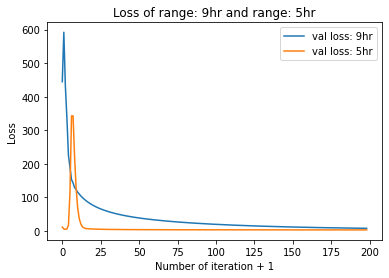

In [122]:
import matplotlib.pyplot as plt

# Loss curve
plt.xlabel("Number of iteration + 1")
plt.ylabel("Loss")
plt.plot(predict_9[1:200]) # 在 iter 較前面時比較可以觀察到趨勢
plt.plot(predict_5[1:200]) # 在 iter 較前面時比較可以觀察到趨勢
plt.title('Loss of range: 9hr and range: 5hr')
plt.legend(['val loss: 9hr', 'val loss: 5hr'])
plt.savefig('Loss of range: 9hr and range: 5hr.png')
plt.show()

## **這裡實作 hw1 第三題：**      
比較只取前 9 hrs 的 PM2.5 和取所有前 9 hrs 的 features（9 * 1 + 1 vs. 9 * 18 + 1）在 validation set上預測的結果，並說明造成的可能原因。    

In [ ]:
# 這裡實作只取 PM 2.5 這個 feature，記得使用 train、val set

# 重新建構我們的 train_set 與 val_set
x_train_set_p = np.ones([math.floor(12 * 471*0.8), 9 * 1]) # 建構 x_train_set_5，初始都為 1
x_validation_p = np.ones([1131, 9 * 1]) # 建構 x_validation_p，初始都為 1
for i in range(len(x_train_set)): # 重新賦值
    x_train_set_p[i][0:9] = x_train_set[i][81:90] # 拿取 pm 2.5 data only

for i in range(len(x_validation)): # 重新賦值
    x_validation_p[i][0:9] = x_validation[i][81:90] # 拿取 pm 2.5 data only

dim = 9 * 1 + 1 # 因為常數項 (bias) 所以多加一欄
w_p = np.zeros([dim, 1])
x_train_set_p = np.concatenate((np.ones([math.floor(12 * 471*0.8), 1]), x_train_set_p), axis = 1).astype(float) # 使用 np.concatenate 對 "axis = 1 (行)" 的數組拼接
x_validation_p = np.concatenate((np.ones([1131, 1]), x_validation_p), axis = 1).astype(float)
train_loss_p = []
predict_p = []

learning_rate = 200 # 每次移動多少
iter_time = 40000 # 進行幾次
adagrad = np.zeros([dim, 1])
eps = 0.0000000001
for t in range(iter_time):
    # for training process
    loss = np.sqrt(np.sum(np.power(np.dot(x_train_set_p, w_p) - y_train_set, 2))/471/12) # rmse
    train_loss_p.append(loss)
    gradient = 2 * np.dot(x_train_set_p.transpose(), np.dot(x_train_set_p, w_p) - y_train_set) # dim*1
    adagrad += gradient ** 2
    w_p = w_p - learning_rate * gradient / np.sqrt(adagrad + eps)

    # for validation process
    val_loss = np.sqrt(np.sum(np.power(np.dot(x_validation_p, w_p) - y_validation, 2))/471/12)
    predict_p.append(val_loss) # rmse

    if(t%100==0): # 每 train 100 次顯示出結果
        print('iter =', t ,' train_loss =', str(loss),' val_loss =', val_loss)

np.save('weight_p.npy', w_p) # 將最後的 w 以 "weight_p.npy" 儲存起來
# print(w_p)

### 秀出第三題的比較圖

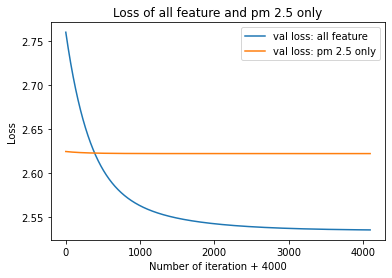

In [132]:
import matplotlib.pyplot as plt

# Loss curve
plt.xlabel("Number of iteration + 4000")
plt.ylabel("Loss")
plt.plot(predict_9[900:5000]) # 在 iter 較前面時比較可以觀察到趨勢
plt.plot(predict_p[900:5000]) # 在 iter 較前面時比較可以觀察到趨勢
# plt.plot(train_loss_9[:400]) # 在 iter 較前面時比較可以觀察到趨勢
# plt.plot(train_loss_p[:400]) # 在 iter 較前面時比較可以觀察到趨勢
plt.title('Loss of all feature and pm 2.5 only')
plt.legend(['val loss: all feature', 'val loss: pm 2.5 only'])
plt.savefig('Loss of all feature and pm 2.5 only.png')
plt.show()

# **Training**
![alt text](https://drive.google.com/uc?id=1xIXvqZ4EGgmxrp7c9r0LOVbcvd4d9H4N)
![alt text](https://drive.google.com/uc?id=1S42g06ON5oJlV2f9RukxawjbE4NpsaB6)
![alt text](https://drive.google.com/uc?id=1BbXu-oPB9EZBHDQ12YCkYqtyAIil3bGj)

(和上圖不同處: 下面的 code 採用 Root Mean Square Error)

因為常數項的存在，所以 dimension (dim) 需要多加一欄；eps 項是避免 adagrad 的分母為 0 而加的極小數值。

每一個 dimension (dim) 會對應到各自的 gradient, weight (w)，透過一次次的 iteration (iter_time) 學習。

## **這裡實作 hw1 第一題**：    
使用四種不同的 learning rate 進行 training (其他參數需一致)，作圖並討論其收斂過程（橫軸為 iteration 次數，縱軸為 loss 的大小，四種 learning rate 的收斂線請以不同顏色呈現在一張圖裡做比較）。

In [ ]:
dim = 18 * 9 + 1 # 因為常數項 (bias) 所以多加一欄
train_loss = []
learning_rate = [0.1, 1, 10, 100] # 每次移動多少
x = np.concatenate((np.ones([12 * 471, 1]), x), axis = 1).astype(float) # 使用 np.concatenate 對 "axis = 1 (行)" 的數組拼接
iter_time = 40000 # 進行幾次
eps = 0.0000000001
for lr in learning_rate:
    print('learining rate =', lr)
    train_loss_lr = []
    w = np.zeros([dim, 1])
    adagrad = np.zeros([dim, 1])
    for t in range(iter_time):
        loss = np.sqrt(np.sum(np.power(np.dot(x, w) - y, 2))/471/12) # rmse
        train_loss_lr.append(loss)
        if(t%100==0): # 每 train 100 次顯示出結果
            print(str(t) + ":" + str(loss))
        gradient = 2 * np.dot(x.transpose(), np.dot(x, w) - y) # dim*1
        adagrad += gradient ** 2
        w = w - lr * gradient / np.sqrt(adagrad + eps)
    train_loss.append(train_loss_lr)
    print('--------------------------------------------------------')
np.save('weight.npy', w) # 將最後的 w 以 "weight.npy" 儲存起來
print(w)

# **Testing**
![alt text](https://drive.google.com/uc?id=1165ETzZyE6HStqKvgR0gKrJwgFLK6-CW)

載入 test data，並且以相似於訓練資料預先處理和特徵萃取的方式處理，使 test data 形成 240 個維度為 18 * 9 + 1 的資料。

In [ ]:
testdata = pd.read_csv('./test.csv', header = None, encoding = 'big5')
test_data = testdata.iloc[:, 2:]
test_data[test_data == 'NR'] = 0
test_data = test_data.to_numpy()
test_x = np.empty([240, 18*9], dtype = float)
for i in range(240):
    test_x[i, :] = test_data[18 * i: 18* (i + 1), :].reshape(1, -1)
for i in range(len(test_x)):
    for j in range(len(test_x[0])):
        if std_x[j] != 0:
            test_x[i][j] = (test_x[i][j] - mean_x[j]) / std_x[j]
test_x = np.concatenate((np.ones([240, 1]), test_x), axis = 1).astype(float)
print(test_x)

# **Prediction**
說明圖同上

![alt text](https://drive.google.com/uc?id=1165ETzZyE6HStqKvgR0gKrJwgFLK6-CW)

有了 weight 和測試資料即可預測 target。

In [ ]:
w = np.load('weight.npy')
ans_y = np.dot(test_x, w)
print(ans_y)

## 秀出第一題的比較圖

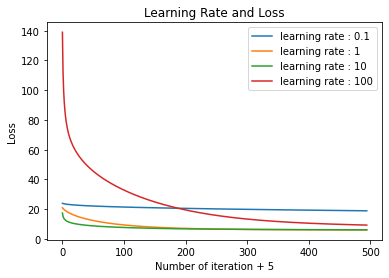

In [133]:
import matplotlib.pyplot as plt

# Loss curve
plt.xlabel("Number of iteration + 5")
plt.ylabel("Loss")
plt.plot(train_loss[0][5:500]) # 在 iter 較前面時比較可以觀察到趨勢
plt.plot(train_loss[1][5:500]) # 在 iter 較前面時比較可以觀察到趨勢
plt.plot(train_loss[2][5:500]) # 在 iter 較前面時比較可以觀察到趨勢
plt.plot(train_loss[3][5:500]) # 在 iter 較前面時比較可以觀察到趨勢
plt.title('Learning Rate and Loss')
plt.legend(['learning rate : 0.1', 'learning rate : 1', 'learning rate : 10', 'learning rate : 100'])
plt.savefig('learning rate and loss.png')
plt.show()


# **Save Prediction to CSV File**


In [ ]:
import csv
with open('submit.csv', mode='w', newline='') as submit_file:
    csv_writer = csv.writer(submit_file)
    header = ['id', 'value']
    print(header)
    csv_writer.writerow(header)
    for i in range(240):
        row = ['id_' + str(i), ans_y[i][0]]
        csv_writer.writerow(row)
        print(row)

# 將結果存到本機端
from google.colab import files
files.download('submit.csv')

相關 reference 可以參考:

Adagrad :
https://youtu.be/yKKNr-QKz2Q?list=PLJV_el3uVTsPy9oCRY30oBPNLCo89yu49&t=705 

RMSprop : 
https://www.youtube.com/watch?v=5Yt-obwvMHI 

Adam
https://www.youtube.com/watch?v=JXQT_vxqwIs 


以上 print 的部分主要是為了看一下資料和結果的呈現，拿掉也無妨。另外，在自己的 linux 系統，可以將檔案寫死的的部分換成 sys.argv 的使用 (可在 terminal 自行輸入檔案和檔案位置)。

最後，可以藉由調整 learning rate、iter_time (iteration 次數)、取用 features 的多寡(取幾個小時，取哪些特徵欄位)，甚至是不同的 model 來超越 baseline。

Report 的問題模板請參照 : https://docs.google.com/document/d/1s84RXs2AEgZr54WCK9IgZrfTF-6B1td-AlKR9oqYa4g/edit